# Инфириенс

In [3]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
# from pycocotools.coco import COCO
import time

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models import mobilenet_v3_large
import torch.nn as nn
from torch.nn import functional as F

In [5]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'

classes = 2
classes1 = 156
device

'cpu'

In [39]:
model_d = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=None)
in_features = model_d.roi_heads.box_predictor.cls_score.in_features
model_d.roi_heads.box_predictor = FastRCNNPredictor(in_features, classes)
checkpoint = torch.load('./m1_d/chkpt_model1_d_7.pth', map_location=device)
model_d.load_state_dict(checkpoint['model_state_dict'])
model_d.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [9]:
transform = transforms.Compose([transforms.ToTensor(),])

In [43]:
img_path = '.'
img_name = 'rtsd-frames/autosave16_10_2012_09_59_41_0.jpg'
detection_threshold = 0.2
image1 = Image.open(img_name)

In [44]:
image = transform(image1).to(device)
image = image.unsqueeze(0) # add a batch dimension
outputs = model_d(image)
pred_classes = [i for i in outputs[0]['labels'].cpu().numpy()]
    # get score for all the predicted objects
pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # get boxes above the threshold score
boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
pred_scores

array([], dtype=float32)

In [35]:
boxes

array([[640, 435, 665, 451]])

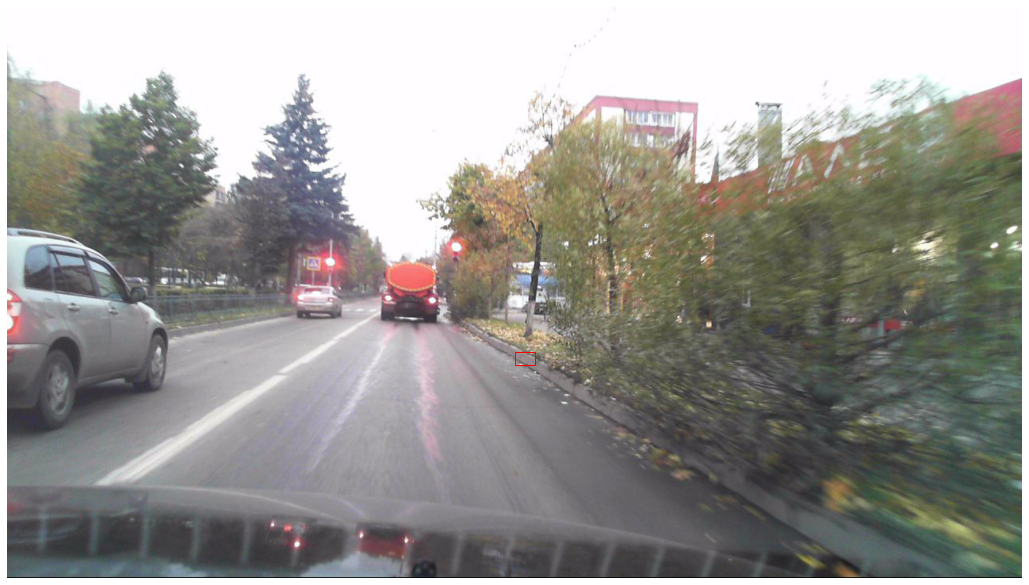

In [36]:
im = Image.open(img_name)

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.imshow(im)
for i in range(len(boxes)):
    rect = patches.Rectangle((boxes[i][0], boxes[i][1]), boxes[i][2] - boxes[i][0], boxes[i][3] - boxes[i][1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')
plt.show()

In [40]:
model_clf = mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V2')
for param in model_clf.parameters(): param.requires_grad = False
model_clf.classifier[3] = nn.Linear(in_features=model_clf.classifier[3].in_features, out_features=classes1)
for param in  model_clf.classifier.parameters(): param.requires_grad = True
checkpoint = torch.load('./m1_clf/chkpt_model1_clf_9.pth', map_location=device)
model_clf.load_state_dict(checkpoint['model_state_dict'])
model_clf.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [45]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [46]:
df_val = dataset('.', 'val_anno.json')

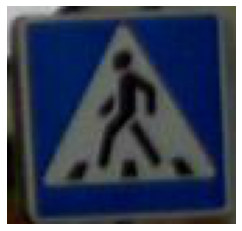

predict: 35
true:    7


In [68]:
y = np.random.choice(df_val.file_name)
im_labels = df_val[df_val.file_name == y].iloc[0]
label = df_val[df_val.file_name == y].iloc[0]['category_id']

im = Image.open('./' + y)
coordinates = [im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]]
cropped = im.crop(coordinates)

plt.imshow(cropped)
plt.axis('off')
plt.show()

image = transform(cropped).to(device)
image = image.unsqueeze(0)
predict = torch.argmax(model_clf(image)).detach().cpu().numpy()

print(f"predict: {predict}")
print(f"true:    {label}")

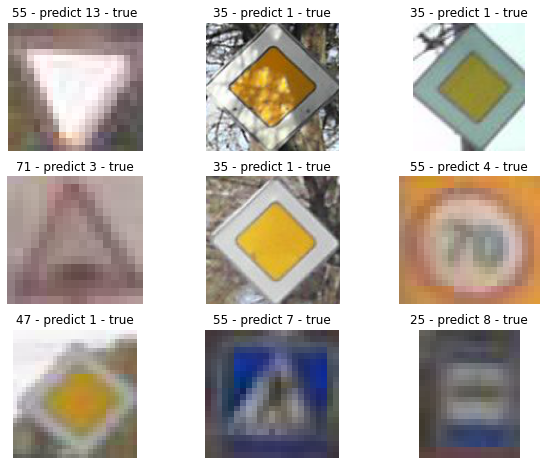

In [83]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_val.file_name)
    im_labels = df_val[df_val.file_name == r].iloc[0]
    label = df_val[df_val.file_name == r].iloc[0]['category_id']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    coordinates = ((im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]))
    cropped = im.crop(coordinates)
    image = transform(cropped).to(device)
    image = image.unsqueeze(0)
    predict = torch.argmax(model_clf(image)).detach().cpu().numpy()
    plt.title('{} - predict {} - true'.format(predict, label))
    plt.imshow(cropped)
    plt.axis("off")
plt.show()

In [69]:
class ResidualBlock(nn.Module):
    """
    Creates the Residual block of ResNet.
    """
    def __init__(
        self, in_channels, out_channels, use_1x1conv=True, strides=1
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.conv3:
            inputs = self.conv3(inputs)
        x += inputs
        return F.relu(x)

In [70]:
def create_resnet_block(
    input_channels,
    output_channels, 
    num_residuals,
):
        resnet_block = []
        for i in range(num_residuals):
            if i == 0:
                resnet_block.append(ResidualBlock(input_channels, output_channels,
                                    use_1x1conv=True, strides=2))
            else:
                resnet_block.append(ResidualBlock(output_channels, output_channels))
        return resnet_block 

In [71]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=156):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(16), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block2 = nn.Sequential(*create_resnet_block(16, 32, 2))
        self.block3 = nn.Sequential(*create_resnet_block(32, 64, 2))
        self.block4 = nn.Sequential(*create_resnet_block(64, 128, 2))
        self.block5 = nn.Sequential(*create_resnet_block(128, 256, 2))
        self.linear = nn.Linear(256, num_classes)
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.linear(x)
        return x 

In [84]:
model_c = CustomResNet()
checkpoint = torch.load('./m22_clf/chkpt_m22_clf_5.pth', map_location=device)
model_c.load_state_dict(checkpoint)#['model_state_dict'])
model_c.eval()

CustomResNet(
  (block1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3): Conv2d(32, 32, kernel_size=

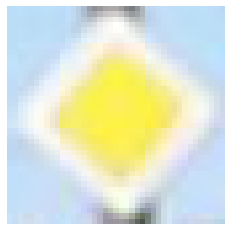

predict: 69
true:    1


In [85]:
y = np.random.choice(df_val.file_name)
im_labels = df_val[df_val.file_name == y].iloc[0]
label = df_val[df_val.file_name == y].iloc[0]['category_id']

im = Image.open('./' + y)
coordinates = [im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]]
cropped = im.crop(coordinates)

plt.imshow(cropped)
plt.axis('off')
plt.show()

image = transform(cropped).to(device)
image = image.unsqueeze(0)
predict = torch.argmax(model_c(image))#.detach().cpu().numpy()

print(f"predict: {predict}")
print(f"true:    {label}")

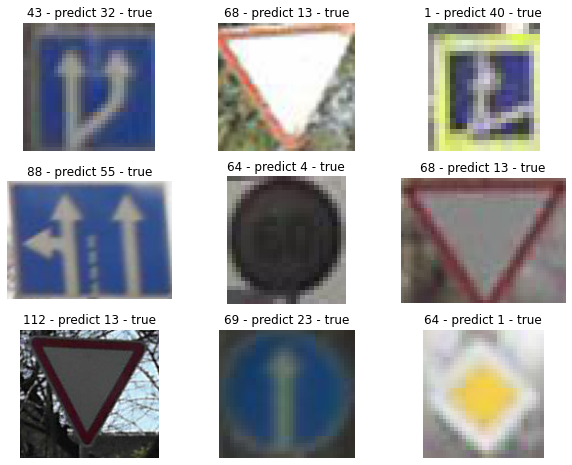

In [86]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    r = np.random.choice(df_val.file_name)
    im_labels = df_val[df_val.file_name == r].iloc[0]
    label = df_val[df_val.file_name == r].iloc[0]['category_id']
    im = Image.open('./' + r)
    figure.add_subplot(rows, cols, i)
    coordinates = ((im_labels.bbox[0], im_labels.bbox[1], im_labels.bbox[0]+im_labels.bbox[2], im_labels.bbox[1]+im_labels.bbox[3]))
    cropped = im.crop(coordinates)
    image = transform(cropped).to(device)
    image = image.unsqueeze(0)
    predict = torch.argmax(model_c(image)).detach().cpu().numpy()
    plt.imshow(cropped)
    plt.title('{} - predict {} - true'.format(predict, label))
    plt.axis("off")
plt.show()